In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/wandb/util.py:35: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, Mapping, Sequence


In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_24122020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 181                 | 182                 | 183                 | 184                 | 185                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-24 00:00:00 | 2020-10-25 00:00:00 | 2020-10-26 00:00:00 | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 249759.14           | 250955.0            | 252085.0            | 252886.0            | 254240.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 2000/2000 [01:15<00:00, 26.57trial/s, best loss: 0.7889977963489471]
best parameters
 {'E_hosp_ratio': 0.3217673651053282, 'I_hosp_ratio': 0.3408739548156282, 'P_fatal': 0.047492659645854515, 'T_inc': 4.555336425392327, 'T_inf': 3.3108108767037376, 'T_recov': 10.278725093148115, 'T_recov_fatal': 38.394802829794436, 'lockdown_R0': 0.8030880562709671}
Performing m2 fit ..
loading from ../../misc/cache/dataframes_ts_24122020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 184                 | 185                 | 186                 | 187                 | 188                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 | 2020-10-29 00:00:00 | 2020-10-30 00:00:00 | 2020-10-31 00:00:00 

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 2000/2000 [01:12<00:00, 27.47trial/s, best loss: 1.1288143200411738]
best parameters
 {'E_hosp_ratio': 0.19788119788626393, 'I_hosp_ratio': 0.33012762477866137, 'P_fatal': 0.038428298797553044, 'T_inc': 4.094433439291914, 'T_inf': 3.2439227537328748, 'T_recov': 10.081394588183901, 'T_recov_fatal': 33.45267875632246, 'lockdown_R0': 0.9230146117577493}


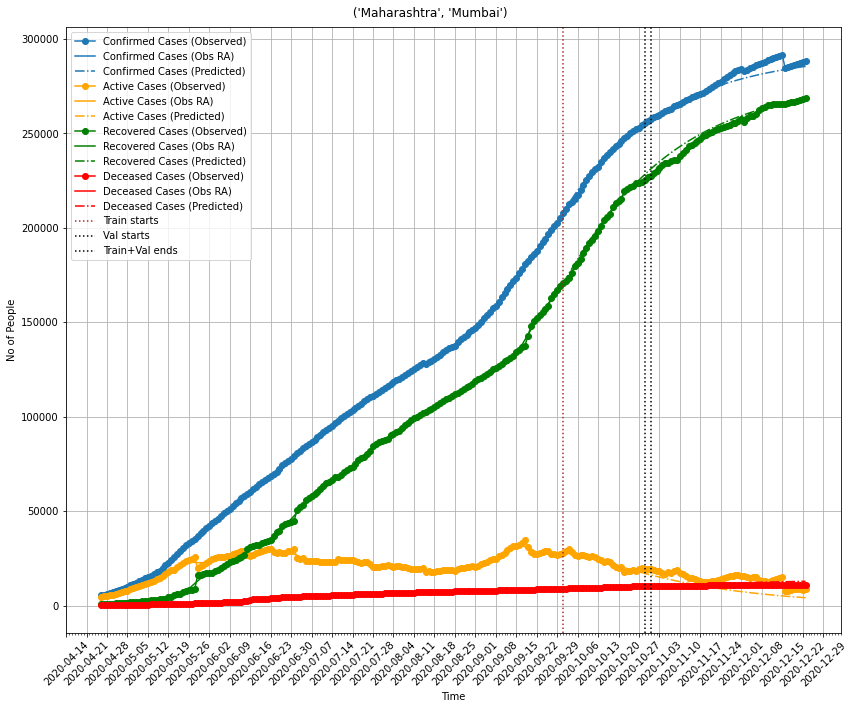

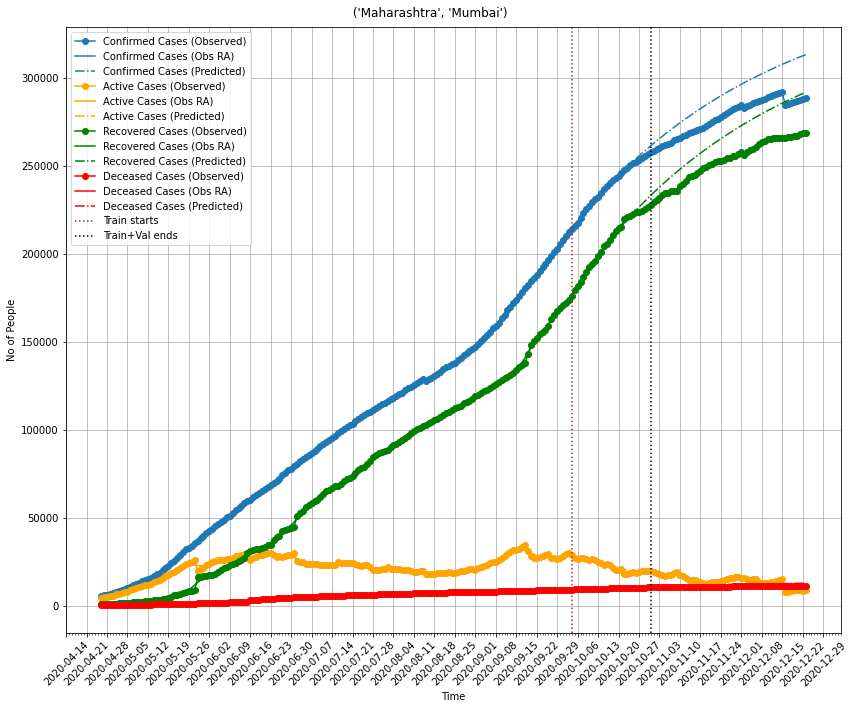

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.3217673651053282,
 'I_hosp_ratio': 0.3408739548156282,
 'P_fatal': 0.047492659645854515,
 'T_inc': 4.555336425392327,
 'T_inf': 3.3108108767037376,
 'T_recov': 10.278725093148115,
 'T_recov_fatal': 38.394802829794436,
 'lockdown_R0': 0.8030880562709671}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.19788119788626393,
 'I_hosp_ratio': 0.33012762477866137,
 'P_fatal': 0.038428298797553044,
 'T_inc': 4.094433439291914,
 'T_inf': 3.2439227537328748,
 'T_recov': 10.081394588183901,
 'T_recov_fatal': 33.45267875632246,
 'lockdown_R0': 0.9230146117577493}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

,train,val,test
total,0.277712,0.130249,0.282531
active,3.3971,15.0192,21.0408
recovered,0.611744,1.3527,1.4247
deceased,0.388934,1.99088,5.92769


### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

,train,test
total,0.427781,3.23622
active,4.27963,6.36511
recovered,0.60229,3.61548
deceased,0.587952,3.56875


## Sensitivity Plot

100%|██████████| 101/101 [00:00<00:00, 101.80it/s]


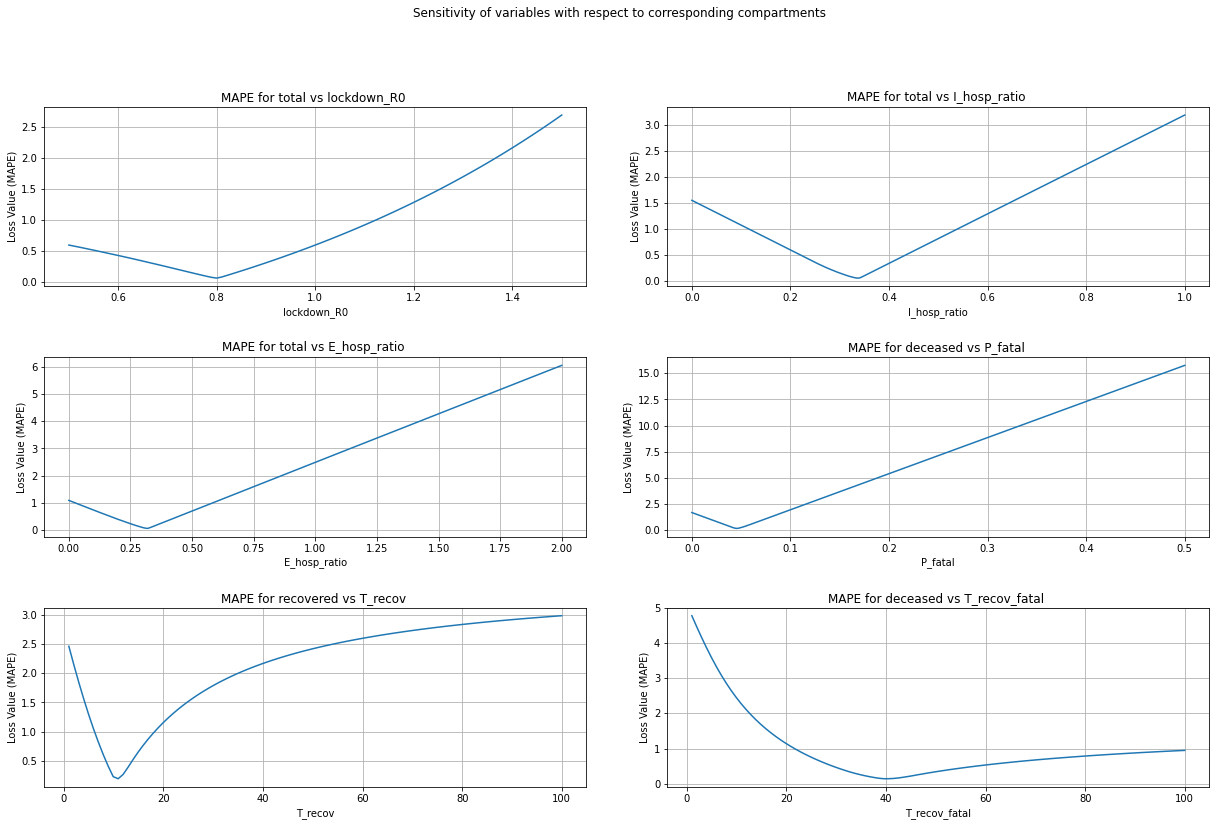

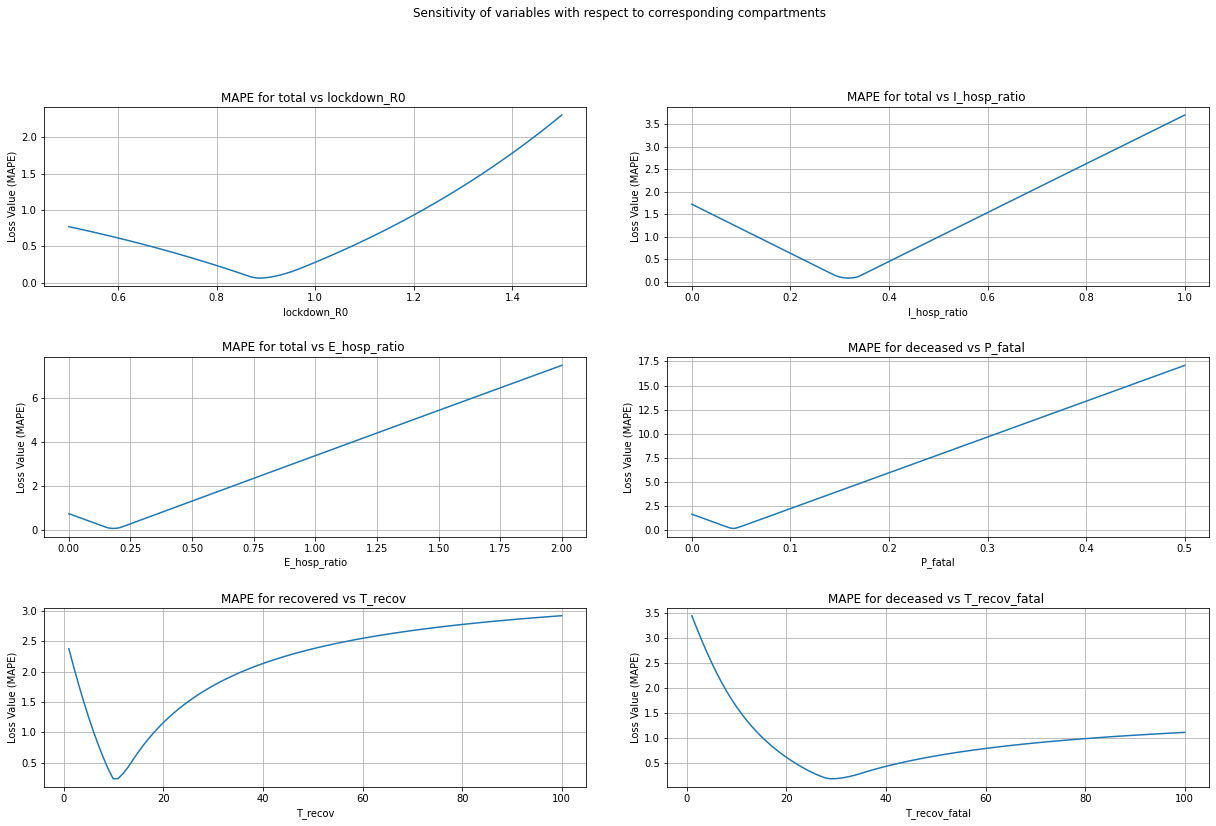

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

getting forecasts ..


11it [00:00, 106.20it/s]

getting forecasts ..


2000it [00:14, 134.60it/s]
14it [00:00, 138.81it/s]

getting forecasts ..


2000it [00:15, 132.46it/s]


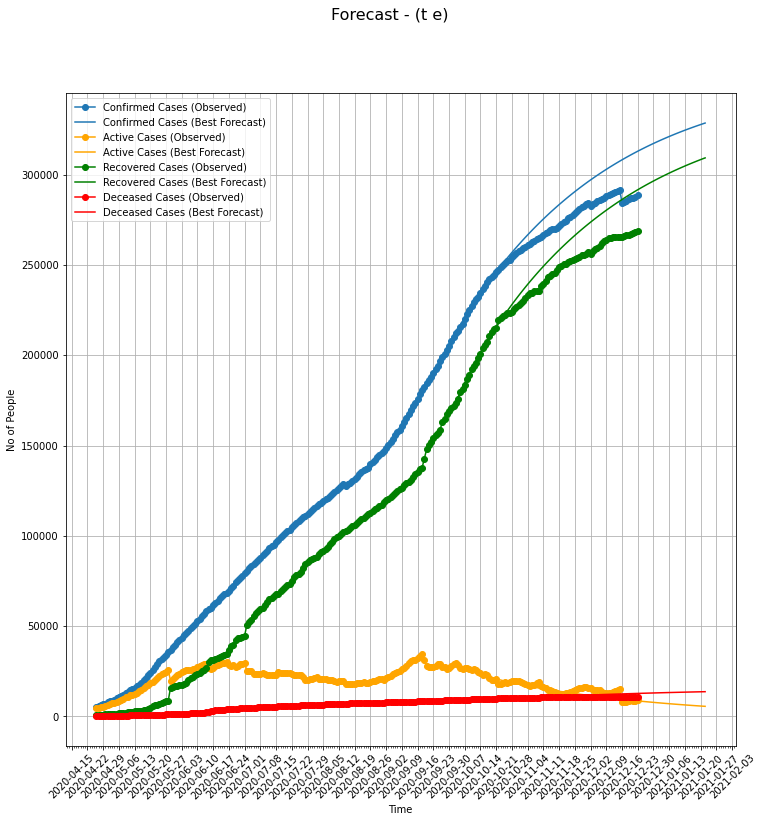

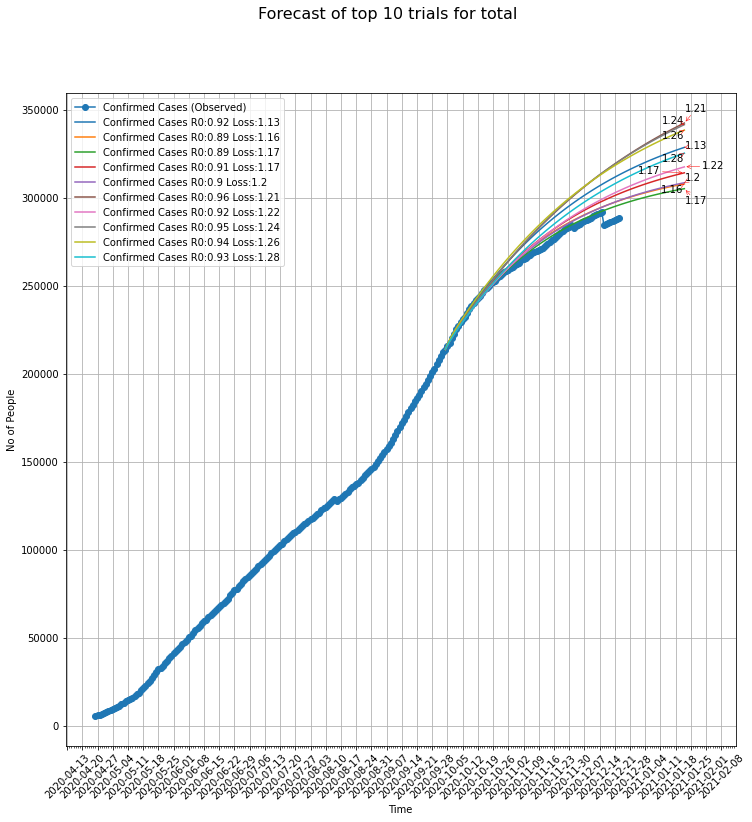

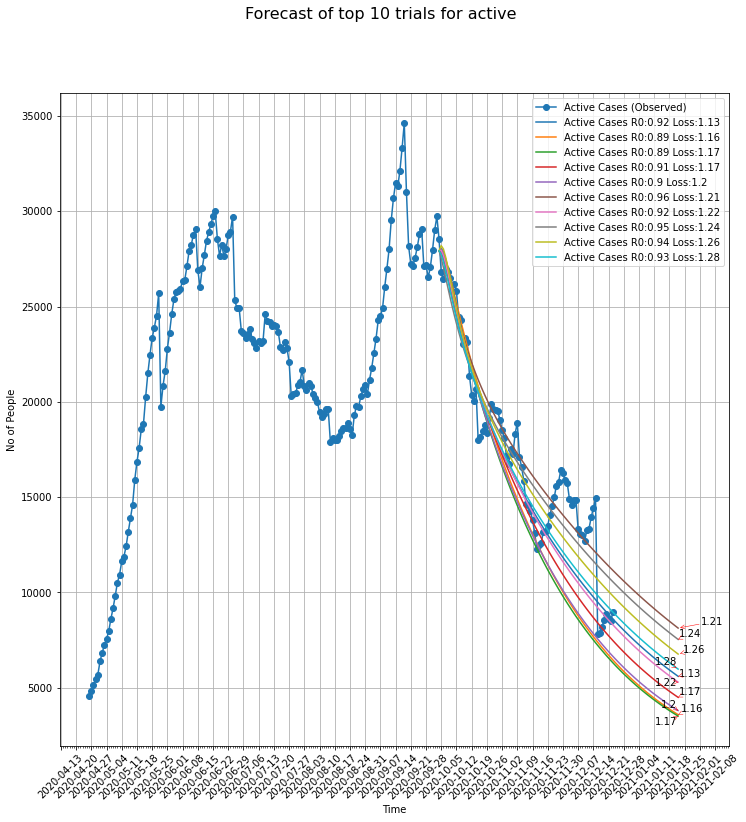

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [13]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

15it [00:00, 141.00it/s]

getting forecasts ..


2000it [00:16, 124.97it/s]
100%|██████████| 101/101 [02:23<00:00,  1.42s/it]


Best beta - 0.0
Min Loss - 3.012586487754077


In [14]:
uncertainty.ensemble_mean_forecast['df_loss']

{'active': 7.163048545832898,
 'recovered': 2.7514476192487782,
 'deceased': 13.028375404423127,
 'total': 3.240265142404893}

In [17]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [18]:
uncertainty_forecasts[2.5]['df_loss_perc']

,train,val,test
total,0.127151,0.211562,0.238979


In [19]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

ValueError: Could not interpret input 'date'

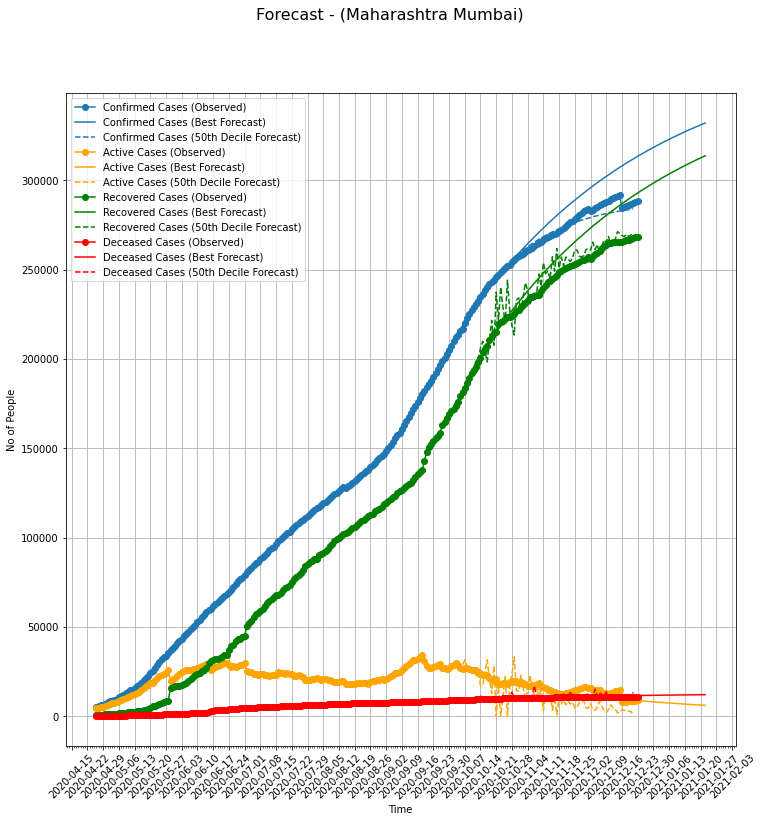

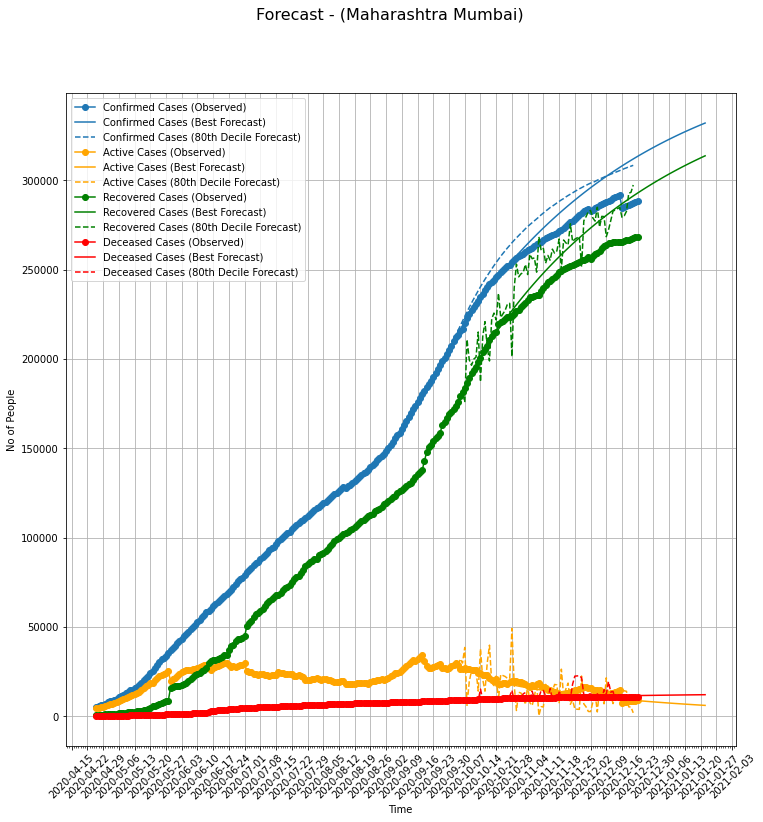

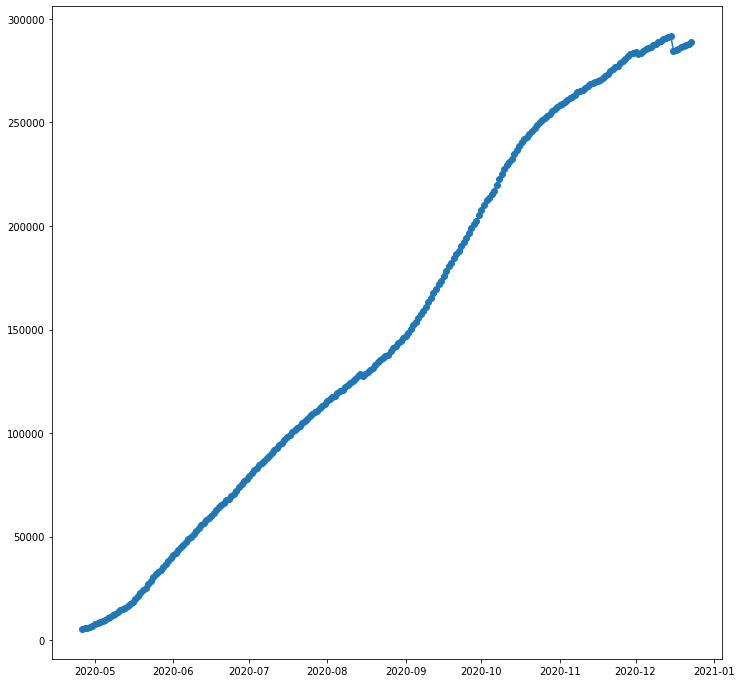

In [20]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [1]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [2]:
a.update(b)

In [3]:
a


{1: [4, 5], 2: [5, 6], 3: [7, 8]}

In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)